# Optimisation Experiment with Optuna

## 1. Import Libraries

In [62]:
from __future__ import print_function
%matplotlib inline
import argparse #generates help messages
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel # implements data parallelism across multiple devices/GPUs
import torch.backends.cudnn as cudnn
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)
import torch.utils.data # for the dataloader class (python iterable over a dataset)
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.transforms as transforms # all transformations for data augmentation (pad, resize, centercrop, ...)
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import optuna
from optuna.trial import TrialState
import logging
from IPython.display import HTML # to embed html in the Ipython output
import datetime
import mlflow

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
logging.basicConfig(level=logging.DEBUG, filename='../reports/02OEwO.log')

## 2. Set the Parameters

In [90]:
dataroot = "../../png/train" # Root directory for train dataset
datarootTest = "../../png/test" # Root directory for dataset
workers = 2 # Number of workers for dataloader
batch_size = 128 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.

In [8]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## 3. Create Dataloader

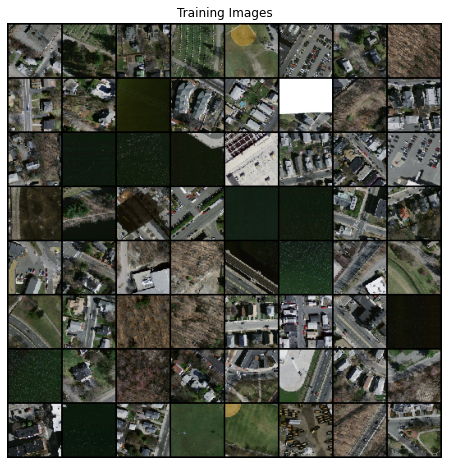

In [49]:
# We can use an image folder dataset the way we have it setup.
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               transforms.RandomCrop(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [50]:
datasetTest = dset.ImageFolder(root=datarootTest,
                               transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               transforms.RandomCrop(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloaderTest = torch.utils.data.DataLoader(datasetTest, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

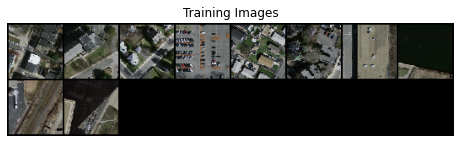

In [56]:
test_batch = next(iter(dataloaderTest))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)));

## 4. Weight Initialization

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # fills the weights? gamma param with normal distribution
        nn.init.constant_(m.bias.data, 0) # fills the bias with the constant 0

# 5. Generator Class

In [14]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution with dimensions c=nz, h=1, w=1
            nn.ConvTranspose2d(in_channels=nz, #deconvolution!
                               out_channels=ngf * 8, 
                               kernel_size=4, 
                               stride=1, 
                               padding=0, 
                               bias=False), #no learnable bias 
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 8, 
                               out_channels=ngf * 4, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf * 4), # accelerates the learning rate by 14 times
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 4, 
                               out_channels=ngf * 2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 2, 
                               out_channels=ngf, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf, 
                               out_channels=nc, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.Tanh() # since the desired output is in range of -1 and +1 (impossible with ReLU and sigmoid D[0,1])
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(module=netG, devide_ids=list(range(ngpu))) # recommended to use DistributedDataParallel instead

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# 6. Discriminator

In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=nc, 
                      out_channels=ndf, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), # (64-4+2)/2 + 1=32
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(in_channels=ndf, 
                      out_channels=ndf * 2, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), # (32-4+2)/2+1=16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=ndf * 2, 
                      out_channels=ndf * 4, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), #(16-4+2)/2+1=8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 4, 
                      out_channels=ndf * 8, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), #(8-4+2)/2+1=4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8, 
                      out_channels=1, 
                      kernel_size=4, 
                      stride=1, 
                      padding=0, 
                      bias=False), #(4-4)/2+1=1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 7. Hyperparam Tuning

In [73]:
# Initialize BCELoss function
criterion = nn.BCELoss() #binary cross entropy, adapt for a probability output and for sigmoid function in D

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param

In [68]:
def train(netG, netD, device, dataloader, optimizerG, optimizerD, epochs):
    
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad() # sets all gradients to 0
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0) # number of images, usually=128, last batch=23
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # size, fill value
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

In [88]:
def test(netG, device, dataloader):
    nz_dim = nz
    errG = []
    for i, data in enumerate(dataloader, 0):
        real = data[0].to(device)
        # batch_size, seq_len = real.size(0), real.size(1)
        batch_size = real.size(0)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        mse = nn.MSELoss()
        with torch.no_grad():
            fake = netG(noise)    
            errG += [mse(fake, real)]
    v = torch.tensor(errG).float().mean().item()
    return v

In [66]:
def suggest_hyperparameters(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    ## dropoutG = trial.suggest_float("dropoutG", 0.0, 0.4, step=0.1)
    ## dropoutD = trial.suggest_float("dropoutD", 0.0, 0.4, step=0.1)
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "Adadelta"])

    return lr, optimizer_name #dropoutG, dropoutD

In [38]:
full_dataset = next(iter(dataloader)) # DatasetLoader("data.csv")
train_size = int(0.8 * len(full_dataset[0]))
print(train_size)

82


In [40]:
test_size = len(full_dataset[0]) - train_size
test_size

21

In [41]:
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset[0], [train_size, test_size])

In [42]:
train_dataset

In [27]:
len(full_dataset[0])

103

In [29]:
len(full_dataset[0][0])

3

In [31]:
len(full_dataset[0][0][0])

64

In [35]:
len(full_dataset[0][0][0][0])

64

In [37]:
full_dataset[0][0][0][0][0].item()

-0.6705882549285889

In [44]:
getattr(optim, "Adam")(netG.parameters(), lr=lr)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

In [45]:
# pip install mlflow

     |████████████████████████████████| 17.6 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 68.0 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 3.6 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 34.9 MB 83.3 MB/s eta 0:00:01     |███████████▍                    | 12.5 MB 83.3 MB/s eta 0:00:01
     |████████████████████████████████| 572 kB 78.9 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 209 kB/s s eta 0:00:01
     |████████████████████████████████| 184 kB 86.1 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.6 MB/s  eta 0:00:01
  Created wheel for databricks-cli: filename=databricks_cli-0.17.4-py3-none-any.whl size=142889 sha256=ad4a9ce6776a3c2e0bca2333b59d43c5b0d72aa2fab1b47652f8a3b44ec274cf
  Stored in directory: /home/furio/.cache/pip/wheels/b3/d4/24/ed7f421c3c600f3eee1a3a9e5c4aecc286a7622cac031918b7
Successfully built databricks-c

In [89]:
def objective(trial: optuna.Trial):
    best_val_loss = float('Inf')
    nz_dim = nz
    best_mse_val = None
    
    # full_dataset = next(iter(dataloader)) # DatasetLoader("data.csv")
    # train_size = int(0.8 * len(full_dataset[0]))
    # test_size = len(full_dataset[0]) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    with mlflow.start_run():

        lr, optimizer_name = suggest_hyperparameters(trial) # dropoutG, dropoutD, 
        n_epochs = 100
        torch.manual_seed(123)
        mlflow.log_params(trial.params)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)

        
        # train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)
        # test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=True)

        # netG = Generator(in_dim=nz_dim, n_channel=10, kernel_size=8, out_dim=1, hidden_dim=100, dropout=dropoutG).to(device)
        # netD = Discriminator(in_dim=1, cnn_layers=4, n_layers=1, kernel_size=8, n_channel=10, dropout=dropoutD, hidden_dim=100).to(device)
        
        netG = Generator(ngpu).to(device)
        netD = Discriminator(ngpu).to(device)
        
        optimizerD = getattr(optim, optimizer_name)(netD.parameters(), lr=lr)
        optimizerG = getattr(optim, optimizer_name)(netG.parameters(), lr=lr)
        
        train(netG, netD, device, dataloader, optimizerG, optimizerD, n_epochs)
        mse_errG = test(netG, device, dataloaderTest)
        
        if best_mse_val is None:
            best_mse_val = mse_errG
        best_mse_val = min(best_mse_val, mse_errG)
        mlflow.log_metric("mse_errG", mse_errG)

    return best_mse_val

In [91]:
run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M")

experiment_id = mlflow.create_experiment(
    f"../reports/TSGAN_Exp_{run_tag}",
    tags={"version": "v1", "priority": "P1"},
)

mlflow.set_experiment(experiment_id=experiment_id)
study = optuna.create_study(study_name=f"TSGAN_study_{run_tag}", direction="minimize")
study.optimize(objective, n_trials=1)

[I 2023-03-04 20:01:11,012] A new study created in memory with name: TSGAN_study_2023-03-04T20:01


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 0.7870	D(x): 0.4382	D(G(z)): 0.4666 / 0.4631
[1/50][0/1]	Loss_D: 1.4898	Loss_G: 0.7957	D(x): 0.4337	D(G(z)): 0.4633 / 0.4599
[2/50][0/1]	Loss_D: 1.4431	Loss_G: 0.8208	D(x): 0.4414	D(G(z)): 0.4506 / 0.4472
[3/50][0/1]	Loss_D: 1.4828	Loss_G: 0.8314	D(x): 0.4238	D(G(z)): 0.4466 / 0.4435
[4/50][0/1]	Loss_D: 1.4991	Loss_G: 0.7994	D(x): 0.4297	D(G(z)): 0.4614 / 0.4581
[5/50][0/1]	Loss_D: 1.4863	Loss_G: 0.7974	D(x): 0.4384	D(G(z)): 0.4633 / 0.4596
[6/50][0/1]	Loss_D: 1.4438	Loss_G: 0.8316	D(x): 0.4446	D(G(z)): 0.4487 / 0.4453
[7/50][0/1]	Loss_D: 1.4743	Loss_G: 0.8069	D(x): 0.4372	D(G(z)): 0.4586 / 0.4550
[8/50][0/1]	Loss_D: 1.4695	Loss_G: 0.7770	D(x): 0.4485	D(G(z)): 0.4714 / 0.4675
[9/50][0/1]	Loss_D: 1.4269	Loss_G: 0.8045	D(x): 0.4571	D(G(z)): 0.4584 / 0.4546
[10/50][0/1]	Loss_D: 1.4565	Loss_G: 0.7992	D(x): 0.4442	D(G(z)): 0.4598 / 0.4561
[11/50][0/1]	Loss_D: 1.4368	Loss_G: 0.7932	D(x): 0.4587	D(G(z)): 0.4643 / 0.4603
[12/50][0/1]

[I 2023-03-04 20:07:12,294] Trial 0 finished with value: 0.6437425017356873 and parameters: {'lr': 0.00037596008395387575, 'optimizer_name': 'Adadelta'}. Best is trial 0 with value: 0.6437425017356873.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 0.0000	D(x): 0.4382	D(G(z)): 0.4666 / 1.0000
[1/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[3/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[4/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000

[I 2023-03-04 20:13:12,641] Trial 1 finished with value: 0.6442872881889343 and parameters: {'lr': 0.05123900027311137, 'optimizer_name': 'Adam'}. Best is trial 0 with value: 0.6437425017356873.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 0.7869	D(x): 0.4382	D(G(z)): 0.4666 / 0.4632
[1/50][0/1]	Loss_D: 1.4899	Loss_G: 0.7956	D(x): 0.4336	D(G(z)): 0.4633 / 0.4599
[2/50][0/1]	Loss_D: 1.4432	Loss_G: 0.8207	D(x): 0.4413	D(G(z)): 0.4506 / 0.4473
[3/50][0/1]	Loss_D: 1.4830	Loss_G: 0.8313	D(x): 0.4237	D(G(z)): 0.4465 / 0.4435
[4/50][0/1]	Loss_D: 1.4994	Loss_G: 0.7993	D(x): 0.4295	D(G(z)): 0.4614 / 0.4581
[5/50][0/1]	Loss_D: 1.4867	Loss_G: 0.7973	D(x): 0.4383	D(G(z)): 0.4632 / 0.4596
[6/50][0/1]	Loss_D: 1.4442	Loss_G: 0.8315	D(x): 0.4444	D(G(z)): 0.4487 / 0.4453
[7/50][0/1]	Loss_D: 1.4748	Loss_G: 0.8068	D(x): 0.4370	D(G(z)): 0.4586 / 0.4551
[8/50][0/1]	Loss_D: 1.4701	Loss_G: 0.7769	D(x): 0.4483	D(G(z)): 0.4714 / 0.4676
[9/50][0/1]	Loss_D: 1.4275	Loss_G: 0.8044	D(x): 0.4568	D(G(z)): 0.4584 / 0.4547
[10/50][0/1]	Loss_D: 1.4571	Loss_G: 0.7990	D(x): 0.4439	D(G(z)): 0.4598 / 0.4561
[11/50][0/1]	Loss_D: 1.4375	Loss_G: 0.7930	D(x): 0.4584	D(G(z)): 0.4643 / 0.4604
[12/50][0/1]

[I 2023-03-04 20:19:13,817] Trial 2 finished with value: 0.6437631249427795 and parameters: {'lr': 0.00036837402492510645, 'optimizer_name': 'Adadelta'}. Best is trial 0 with value: 0.6437425017356873.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 2.9408	D(x): 0.4382	D(G(z)): 0.4666 / 0.0550
[1/50][0/1]	Loss_D: 1.4300	Loss_G: 4.8891	D(x): 0.6941	D(G(z)): 0.6403 / 0.0082
[2/50][0/1]	Loss_D: 1.2207	Loss_G: 1.5710	D(x): 0.4252	D(G(z)): 0.2665 / 0.2135
[3/50][0/1]	Loss_D: 2.3096	Loss_G: 5.7732	D(x): 0.8968	D(G(z)): 0.8839 / 0.0033
[4/50][0/1]	Loss_D: 1.0512	Loss_G: 1.2738	D(x): 0.4434	D(G(z)): 0.1130 / 0.2850
[5/50][0/1]	Loss_D: 2.3304	Loss_G: 6.8387	D(x): 0.9298	D(G(z)): 0.8889 / 0.0012
[6/50][0/1]	Loss_D: 0.8229	Loss_G: 1.6165	D(x): 0.4831	D(G(z)): 0.0398 / 0.2059
[7/50][0/1]	Loss_D: 2.2472	Loss_G: 7.9324	D(x): 0.9409	D(G(z)): 0.8801 / 0.0004
[8/50][0/1]	Loss_D: 0.7182	Loss_G: 2.3045	D(x): 0.5388	D(G(z)): 0.0205 / 0.1043
[9/50][0/1]	Loss_D: 2.0083	Loss_G: 8.3468	D(x): 0.9620	D(G(z)): 0.8525 / 0.0003
[10/50][0/1]	Loss_D: 0.7296	Loss_G: 2.3600	D(x): 0.5303	D(G(z)): 0.0193 / 0.1001
[11/50][0/1]	Loss_D: 2.1233	Loss_G: 8.9624	D(x): 0.9390	D(G(z)): 0.8657 / 0.0001
[12/50][0/1]

[I 2023-03-04 20:25:15,278] Trial 3 finished with value: 0.3301268219947815 and parameters: {'lr': 0.07455976338275612, 'optimizer_name': 'Adadelta'}. Best is trial 3 with value: 0.3301268219947815.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 0.7851	D(x): 0.4382	D(G(z)): 0.4666 / 0.4640
[1/50][0/1]	Loss_D: 1.4907	Loss_G: 0.7939	D(x): 0.4333	D(G(z)): 0.4633 / 0.4607
[2/50][0/1]	Loss_D: 1.4447	Loss_G: 0.8191	D(x): 0.4406	D(G(z)): 0.4505 / 0.4480
[3/50][0/1]	Loss_D: 1.4855	Loss_G: 0.8300	D(x): 0.4226	D(G(z)): 0.4464 / 0.4441
[4/50][0/1]	Loss_D: 1.5026	Loss_G: 0.7982	D(x): 0.4280	D(G(z)): 0.4611 / 0.4586
[5/50][0/1]	Loss_D: 1.4908	Loss_G: 0.7959	D(x): 0.4364	D(G(z)): 0.4630 / 0.4602
[6/50][0/1]	Loss_D: 1.4488	Loss_G: 0.8303	D(x): 0.4423	D(G(z)): 0.4484 / 0.4459
[7/50][0/1]	Loss_D: 1.4805	Loss_G: 0.8055	D(x): 0.4343	D(G(z)): 0.4583 / 0.4556
[8/50][0/1]	Loss_D: 1.4761	Loss_G: 0.7756	D(x): 0.4455	D(G(z)): 0.4711 / 0.4682
[9/50][0/1]	Loss_D: 1.4343	Loss_G: 0.8031	D(x): 0.4536	D(G(z)): 0.4581 / 0.4552
[10/50][0/1]	Loss_D: 1.4643	Loss_G: 0.7978	D(x): 0.4406	D(G(z)): 0.4594 / 0.4567
[11/50][0/1]	Loss_D: 1.4456	Loss_G: 0.7915	D(x): 0.4547	D(G(z)): 0.4640 / 0.4611
[12/50][0/1]

[I 2023-03-04 20:31:16,139] Trial 4 finished with value: 0.6439871788024902 and parameters: {'lr': 0.0002819164066207762, 'optimizer_name': 'Adadelta'}. Best is trial 3 with value: 0.3301268219947815.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 0.7869	D(x): 0.4382	D(G(z)): 0.4666 / 0.4632
[1/50][0/1]	Loss_D: 1.4899	Loss_G: 0.7956	D(x): 0.4336	D(G(z)): 0.4633 / 0.4599
[2/50][0/1]	Loss_D: 1.4432	Loss_G: 0.8207	D(x): 0.4413	D(G(z)): 0.4506 / 0.4473
[3/50][0/1]	Loss_D: 1.4830	Loss_G: 0.8313	D(x): 0.4237	D(G(z)): 0.4465 / 0.4435
[4/50][0/1]	Loss_D: 1.4994	Loss_G: 0.7993	D(x): 0.4295	D(G(z)): 0.4614 / 0.4581
[5/50][0/1]	Loss_D: 1.4867	Loss_G: 0.7973	D(x): 0.4383	D(G(z)): 0.4632 / 0.4596
[6/50][0/1]	Loss_D: 1.4442	Loss_G: 0.8315	D(x): 0.4444	D(G(z)): 0.4487 / 0.4453
[7/50][0/1]	Loss_D: 1.4748	Loss_G: 0.8068	D(x): 0.4370	D(G(z)): 0.4586 / 0.4551
[8/50][0/1]	Loss_D: 1.4700	Loss_G: 0.7769	D(x): 0.4483	D(G(z)): 0.4714 / 0.4676
[9/50][0/1]	Loss_D: 1.4274	Loss_G: 0.8044	D(x): 0.4569	D(G(z)): 0.4584 / 0.4547
[10/50][0/1]	Loss_D: 1.4571	Loss_G: 0.7990	D(x): 0.4439	D(G(z)): 0.4598 / 0.4561
[11/50][0/1]	Loss_D: 1.4375	Loss_G: 0.7930	D(x): 0.4584	D(G(z)): 0.4643 / 0.4604
[12/50][0/1]

[I 2023-03-04 20:37:16,237] Trial 5 finished with value: 0.6437636613845825 and parameters: {'lr': 0.0003686486592007625, 'optimizer_name': 'Adadelta'}. Best is trial 3 with value: 0.3301268219947815.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 0.4949	D(x): 0.4382	D(G(z)): 0.4666 / 0.6690
[1/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[3/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[4/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/50][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000

[I 2023-03-04 20:43:14,207] Trial 6 finished with value: 0.6025742888450623 and parameters: {'lr': 0.017923794695751723, 'optimizer_name': 'Adam'}. Best is trial 3 with value: 0.3301268219947815.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 0.7837	D(x): 0.4382	D(G(z)): 0.4666 / 0.4646
[1/50][0/1]	Loss_D: 1.4913	Loss_G: 0.7925	D(x): 0.4330	D(G(z)): 0.4633 / 0.4613
[2/50][0/1]	Loss_D: 1.4460	Loss_G: 0.8178	D(x): 0.4401	D(G(z)): 0.4504 / 0.4485
[3/50][0/1]	Loss_D: 1.4875	Loss_G: 0.8289	D(x): 0.4217	D(G(z)): 0.4463 / 0.4446
[4/50][0/1]	Loss_D: 1.5052	Loss_G: 0.7974	D(x): 0.4267	D(G(z)): 0.4608 / 0.4590
[5/50][0/1]	Loss_D: 1.4941	Loss_G: 0.7949	D(x): 0.4348	D(G(z)): 0.4628 / 0.4607
[6/50][0/1]	Loss_D: 1.4526	Loss_G: 0.8295	D(x): 0.4405	D(G(z)): 0.4481 / 0.4462
[7/50][0/1]	Loss_D: 1.4852	Loss_G: 0.8046	D(x): 0.4322	D(G(z)): 0.4580 / 0.4560
[8/50][0/1]	Loss_D: 1.4811	Loss_G: 0.7746	D(x): 0.4431	D(G(z)): 0.4708 / 0.4687
[9/50][0/1]	Loss_D: 1.4400	Loss_G: 0.8022	D(x): 0.4509	D(G(z)): 0.4578 / 0.4557
[10/50][0/1]	Loss_D: 1.4703	Loss_G: 0.7970	D(x): 0.4378	D(G(z)): 0.4591 / 0.4571
[11/50][0/1]	Loss_D: 1.4523	Loss_G: 0.7906	D(x): 0.4516	D(G(z)): 0.4637 / 0.4615
[12/50][0/1]

[I 2023-03-04 20:49:12,308] Trial 7 finished with value: 0.6441247463226318 and parameters: {'lr': 0.00021072698205120132, 'optimizer_name': 'Adadelta'}. Best is trial 3 with value: 0.3301268219947815.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 2.0413	D(x): 0.4382	D(G(z)): 0.4666 / 0.1345
[1/50][0/1]	Loss_D: 1.2164	Loss_G: 2.0543	D(x): 0.6098	D(G(z)): 0.4974 / 0.1348
[2/50][0/1]	Loss_D: 1.0006	Loss_G: 2.3500	D(x): 0.6839	D(G(z)): 0.4474 / 0.1005
[3/50][0/1]	Loss_D: 0.9019	Loss_G: 2.5698	D(x): 0.7104	D(G(z)): 0.4120 / 0.0803
[4/50][0/1]	Loss_D: 0.8596	Loss_G: 2.7590	D(x): 0.7238	D(G(z)): 0.3946 / 0.0687
[5/50][0/1]	Loss_D: 0.8451	Loss_G: 2.9700	D(x): 0.7305	D(G(z)): 0.3957 / 0.0541
[6/50][0/1]	Loss_D: 0.8189	Loss_G: 3.3339	D(x): 0.7190	D(G(z)): 0.3678 / 0.0379
[7/50][0/1]	Loss_D: 0.7415	Loss_G: 3.7463	D(x): 0.7469	D(G(z)): 0.3448 / 0.0249
[8/50][0/1]	Loss_D: 0.6922	Loss_G: 4.2099	D(x): 0.7377	D(G(z)): 0.2986 / 0.0162
[9/50][0/1]	Loss_D: 0.5618	Loss_G: 4.6245	D(x): 0.7886	D(G(z)): 0.2611 / 0.0105
[10/50][0/1]	Loss_D: 0.5418	Loss_G: 5.0613	D(x): 0.7642	D(G(z)): 0.2052 / 0.0069
[11/50][0/1]	Loss_D: 0.4383	Loss_G: 5.4517	D(x): 0.7877	D(G(z)): 0.1504 / 0.0046
[12/50][0/1]

[I 2023-03-04 20:55:11,117] Trial 8 finished with value: 0.6591585874557495 and parameters: {'lr': 0.00012473731512350822, 'optimizer_name': 'Adam'}. Best is trial 3 with value: 0.3301268219947815.


Starting Training Loop...
[0/50][0/1]	Loss_D: 1.4839	Loss_G: 0.8232	D(x): 0.4382	D(G(z)): 0.4666 / 0.4470
[1/50][0/1]	Loss_D: 1.4747	Loss_G: 0.8317	D(x): 0.4407	D(G(z)): 0.4642 / 0.4440
[2/50][0/1]	Loss_D: 1.4126	Loss_G: 0.8566	D(x): 0.4554	D(G(z)): 0.4519 / 0.4317
[3/50][0/1]	Loss_D: 1.4348	Loss_G: 0.8637	D(x): 0.4456	D(G(z)): 0.4487 / 0.4296
[4/50][0/1]	Loss_D: 1.4362	Loss_G: 0.8320	D(x): 0.4597	D(G(z)): 0.4650 / 0.4436
[5/50][0/1]	Loss_D: 1.4067	Loss_G: 0.8402	D(x): 0.4739	D(G(z)): 0.4640 / 0.4407
[6/50][0/1]	Loss_D: 1.3554	Loss_G: 0.8738	D(x): 0.4832	D(G(z)): 0.4484 / 0.4267
[7/50][0/1]	Loss_D: 1.3638	Loss_G: 0.8599	D(x): 0.4843	D(G(z)): 0.4556 / 0.4322
[8/50][0/1]	Loss_D: 1.3501	Loss_G: 0.8387	D(x): 0.4973	D(G(z)): 0.4647 / 0.4397
[9/50][0/1]	Loss_D: 1.2913	Loss_G: 0.8719	D(x): 0.5125	D(G(z)): 0.4492 / 0.4249
[10/50][0/1]	Loss_D: 1.3161	Loss_G: 0.8715	D(x): 0.4994	D(G(z)): 0.4490 / 0.4252
[11/50][0/1]	Loss_D: 1.2795	Loss_G: 0.8767	D(x): 0.5200	D(G(z)): 0.4494 / 0.4243
[12/50][0/1]

[I 2023-03-04 21:01:11,342] Trial 9 finished with value: 0.628750741481781 and parameters: {'lr': 0.0021398231870723284, 'optimizer_name': 'Adadelta'}. Best is trial 3 with value: 0.3301268219947815.


## 99. ARCHIVE - Define Optimisation Classes for Generator

Furio's Comment: 

in original GANs there are two metrics to optimize, the generator and the discriminator loss

In the optimisation example (https://github.com/elena-ecn/optuna-optimization-for-PyTorch-CNN/blob/main/optuna_optimization.py) there is a single model that is optimized for accuracy. 
My hypothesis is that in optuna both of the models need to be considered in the optimisation.

<b>About the layer Structure:</b> </br>
we need in any case transposed Convolutions till
the desired output size (64x64) is achieved.
Therefore I'm starting with the same layers as in the original example. On top of it it is possible to add one or more extra transposed convolutions that do not influence the size

In [ ]:
###class Generator(nn.Module):
###    """CNN for the MNIST dataset of handwritten digits.
###    Attributes:
###        - convs (torch.nn.modules.container.ModuleList):   List with the convolutional layers
###        - conv2_drop (torch.nn.modules.dropout.Dropout2d): Dropout for conv layer 2
###        - out_feature (int):                               Size of flattened features
###        - fc1 (torch.nn.modules.linear.Linear):            Fully Connected layer 1
###        - fc2 (torch.nn.modules.linear.Linear):            Fully Connected layer 2
###        - p1 (float):                                      Dropout ratio for FC1
###    Methods:
###        - forward(x): Does forward propagation
###    """
###    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1):
###        """Parameters:
###            - trial (optuna.trial._trial.Trial): Optuna trial
###            - num_conv_layers (int):             Number of convolutional layers
###            - num_filters (list):                Number of filters of conv layers
###            - num_neurons (int):                 Number of neurons of FC layers
###            - drop_conv2 (float):                Dropout ratio for conv layer 2
###            - drop_fc1 (float):                  Dropout ratio for FC1
###        """
###        super(Generator, self).__init__()                                               # Initialize parent class
###        in_size = nz                                                                    # Input noise size
###        ksize = 4                                                                       # Convolution filter size
###        stride = 2
###        padding = 1
###
###        # Define the convolutional layers
###        self.convs = nn.ModuleList([nn.ConvTranspose2d(1, num_filters[0], 
###                                                       kernel_size=ksize,
###                                                       stride=stride,
###                                                       padding=padding)])               # List with the Conv layers
###        out_size = int((in_size - ksize + 2 * padding) / stride) + 1                    # Size of the output kernel
###        # out_size = int(out_size / 2)                                                  # Size after pooling
###        
###        
###        
###        
###        for i in range(1, num_conv_layers):
###            self.convs.append(nn.ConvTranspose2d(in_channels=num_filters[i-1], out_channels=num_filters[i], 
###                                                 kernel_size=ksize, stride = stride, padding=padding,
###                                                 bias=False))
###            out_size = int((in_size - ksize + 2 * padding) / stride) + 1                # Size of the output kernel
###            # out_size = int(out_size/2)                                                # Size after pooling
###            
###
###        self.conv2_drop = nn.Dropout2d(p=drop_conv2)                                    # Dropout for conv2
###        self.out_feature = num_filters[num_conv_layers-1] * out_size * out_size         # Size of flattened features
###        self.fc1 = nn.Linear(self.out_feature, num_neurons)                             # Fully Connected layer 1
###        self.fc2 = nn.Linear(num_neurons, 10)                                           # Fully Connected layer 2
###        self.p1 = drop_fc1                                                              # Dropout ratio for FC1
###
###        # Initialize weights with the He initialization
###        for i in range(1, num_conv_layers):
###            nn.init.kaiming_normal_(self.convs[i].weight, nonlinearity='relu')
###            if self.convs[i].bias is not None:
###                nn.init.constant_(self.convs[i].bias, 0)
###        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
###
###    def forward(self, x):
###        """Forward propagation.
###        Parameters:
###            - x (torch.Tensor): Input tensor of size [N,1,28,28]
###        Returns:
###            - (torch.Tensor): The output tensor after forward propagation [N,10]
###        """
###        for i, conv_i in enumerate(self.convs):  # For each convolutional layer
###            if i == 2:  # Add dropout if layer 2
###                x = F.relu(F.max_pool2d(self.conv2_drop(conv_i(x)), 2))  # Conv_i, dropout, max-pooling, RelU
###            else:
###                x = F.relu(F.max_pool2d(conv_i(x), 2))                   # Conv_i, max-pooling, RelU
###
###        x = x.view(-1, self.out_feature)                     # Flatten tensor
###        x = F.relu(self.fc1(x))                              # FC1, RelU
###        x = F.dropout(x, p=self.p1, training=self.training)  # Apply dropout after FC1 only when training
###        x = self.fc2(x)                                      # FC2
###
###        return F.log_softmax(x, dim=1)                       # log(softmax(x))
###
###
###    def train(network, optimizer):
###        """Trains the model.
###        Parameters:
###            - network (__main__.Net):              The CNN
###            - optimizer (torch.optim.<optimizer>): The optimizer for the CNN
###        """
###        network.train()  # Set the module in training mode (only affects certain modules)
###        for batch_i, (data, target) in enumerate(train_loader):  # For each batch
###
###            # Limit training data for faster computation
###            if batch_i * batch_size_train > number_of_train_examples:
###                break
###
###            optimizer.zero_grad()                                 # Clear gradients
###            output = network(data.to(device))                     # Forward propagation
###            loss = F.nll_loss(output, target.to(device))          # Compute loss (negative log likelihood: −log(y))
###            loss.backward()                                       # Compute gradients
###            optimizer.step()                                      # Update weights
###
###
###    def test(network):
###        """Tests the model.
###        Parameters:
###            - network (__main__.Net): The CNN
###        Returns:
###            - accuracy_test (torch.Tensor): The test accuracy
###        """
###        network.eval()         # Set the module in evaluation mode (only affects certain modules)
###        correct = 0
###        with torch.no_grad():  # Disable gradient calculation (when you are sure that you will not call Tensor.backward())
###            for batch_i, (data, target) in enumerate(test_loader):  # For each batch
###
###                # Limit testing data for faster computation
###                if batch_i * batch_size_test > number_of_test_examples:
###                    break
###
###                output = network(data.to(device))               # Forward propagation
###                pred = output.data.max(1, keepdim=True)[1]      # Find max value in each row, return indexes of max values
###                correct += pred.eq(target.to(device).data.view_as(pred)).sum()  # Compute correct predictions
###
###        accuracy_test = correct / len(test_loader.dataset)
###
###        return accuracy_test
###
###
###    def objective(trial):
###        """Objective function to be optimized by Optuna.
###        Hyperparameters chosen to be optimized: optimizer, learning rate,
###        dropout values, number of convolutional layers, number of filters of
###        convolutional layers, number of neurons of fully connected layers.
###        Inputs:
###            - trial (optuna.trial._trial.Trial): Optuna trial
###        Returns:
###            - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
###        """
###
###        # Define range of values to be tested for the hyperparameters
###        num_conv_layers = trial.suggest_int("num_conv_layers", 2, 3)  # Number of convolutional layers
###        num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
###                       for i in range(num_conv_layers)]              # Number of filters for the convolutional layers
###        num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of FC1 layer
###        drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)     # Dropout for convolutional layer 2
###        drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)         # Dropout for FC1 layer
###
###        # Generate the model
###        model = Generator(trial, num_conv_layers, num_filters, num_neurons, drop_conv2,  drop_fc1).to(device)
###
###        # Generate the optimizers
###        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])  # Optimizers
###        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)                                 # Learning rates
###        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
###
###        # Training of the model
###        for epoch in range(n_epochs):
###            train(model, optimizer)  # Train the model
###            accuracy = test(model)   # Evaluate the model
###
###            # For pruning (stops trial early if not promising)
###            trial.report(accuracy, epoch)
###            # Handle pruning based on the intermediate value.
###            if trial.should_prune():
###                raise optuna.exceptions.TrialPruned()
###
###        return accuracy

In [ ]:
### # -------------------------------------------------------------------------
### # Optimization study for a PyTorch CNN with Optuna
### # -------------------------------------------------------------------------
### 
### # Use cuda if available for faster computations
### device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
### 
### # --- Parameters ----------------------------------------------------------
### n_epochs = 10                         # Number of training epochs
### batch_size_train = 64                 # Batch size for training data
### batch_size_test = 1000                # Batch size for testing data
### number_of_trials = 100                # Number of Optuna trials
### limit_obs = True                      # Limit number of observations for faster computation
### 
### # *** Note: For more accurate results, do not limit the observations.
### #           If not limited, however, it might take a very long time to run.
### #           Another option is to limit the number of epochs. ***
### 
### if limit_obs:  # Limit number of observations
###     number_of_train_examples = 500 * batch_size_train  # Max train observations
###     number_of_test_examples = 5 * batch_size_test      # Max test observations
### else:
###     number_of_train_examples = 60000                   # Max train observations
###     number_of_test_examples = 10000                    # Max test observations
### # -------------------------------------------------------------------------
### 
### # Make runs repeatable
### random_seed = 1
### torch.backends.cudnn.enabled = False  # Disable cuDNN use of nondeterministic algorithms
### torch.manual_seed(random_seed)
### 
### # Create directory 'files', if it doesn't exist, to save the dataset
### directory_name = 'files'
### if not os.path.exists(directory_name):
###     os.mkdir(directory_name)
### 
### # Download MNIST dataset to 'files' directory and normalize it
### ## train_loader = torch.utils.data.DataLoader(
### ##     torchvision.datasets.MNIST('/files/', train=True, download=True,
### ##                                transform=torchvision.transforms.Compose([
### ##                                    torchvision.transforms.ToTensor(),
### ##                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
### ##     batch_size=batch_size_train, shuffle=True)
### ## 
### ## test_loader = torch.utils.data.DataLoader(
### ##     torchvision.datasets.MNIST('/files/', train=False, download=True,
### ##                                transform=torchvision.transforms.Compose([
### ##                                    torchvision.transforms.ToTensor(),
### ##                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
### ##     batch_size=batch_size_test, shuffle=True)
### 
### # Create an Optuna study to maximize test accuracy
### study = optuna.create_study(direction="maximize")
### study.optimize(objective, n_trials=number_of_trials)
### 
### # -------------------------------------------------------------------------
### # Results
### # -------------------------------------------------------------------------
### 
### # Find number of pruned and completed trials
### pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
### complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
### 
### # Display the study statistics
### print("\nStudy statistics: ")
### print("  Number of finished trials: ", len(study.trials))
### print("  Number of pruned trials: ", len(pruned_trials))
### print("  Number of complete trials: ", len(complete_trials))
### 
### trial = study.best_trial
### print("Best trial:")
### print("  Value: ", trial.value)
### print("  Params: ")
### for key, value in trial.params.items():
###     print("    {}: {}".format(key, value))
### 
### # Save results to csv file
### df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
### df = df.loc[df['state'] == 'COMPLETE']        # Keep only results that did not prune
### df = df.drop('state', axis=1)                 # Exclude state column
### df = df.sort_values('value')                  # Sort based on accuracy
### df.to_csv('optuna_results.csv', index=False)  # Save to csv file
### 
### # Display results in a dataframe
### print("\nOverall Results (ordered by accuracy):\n {}".format(df))
### 
### # Find the most important hyperparameters
### most_important_parameters = optuna.importance.get_param_importances(study, target=None)
### 
### # Display the most important hyperparameters
### print('\nMost important hyperparameters:')
### for key, value in most_important_parameters.items():
###     print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))